In [55]:
globals().clear()

import geopandas as gpd
import matplotlib.pyplot as plt
import os
import numpy as np


os.chdir('C:/Users/lbeatty/Documents/Lauren_MIP_Contribution/')

scenario = '26z-thin-debug'
model='SWITCH'

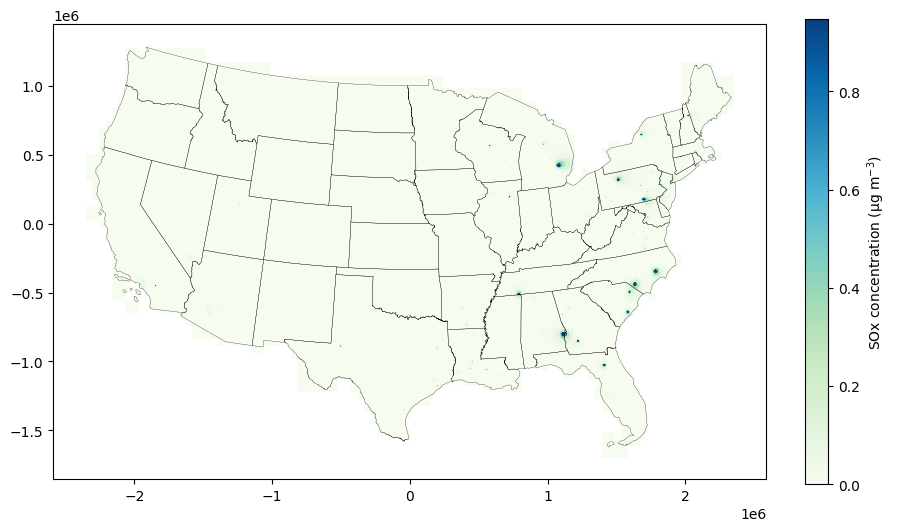

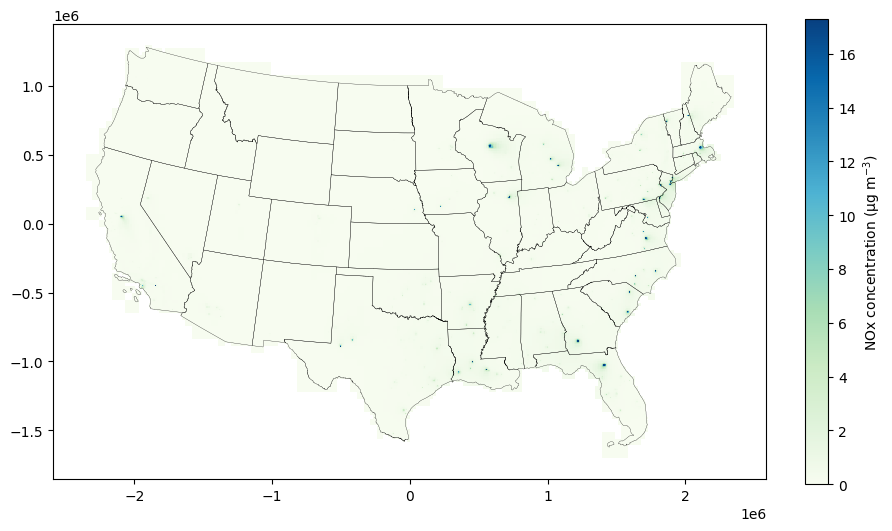

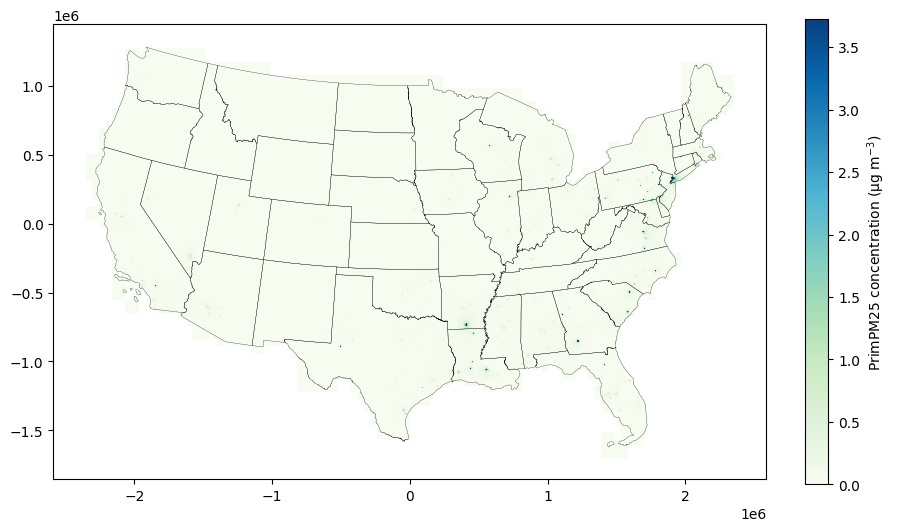

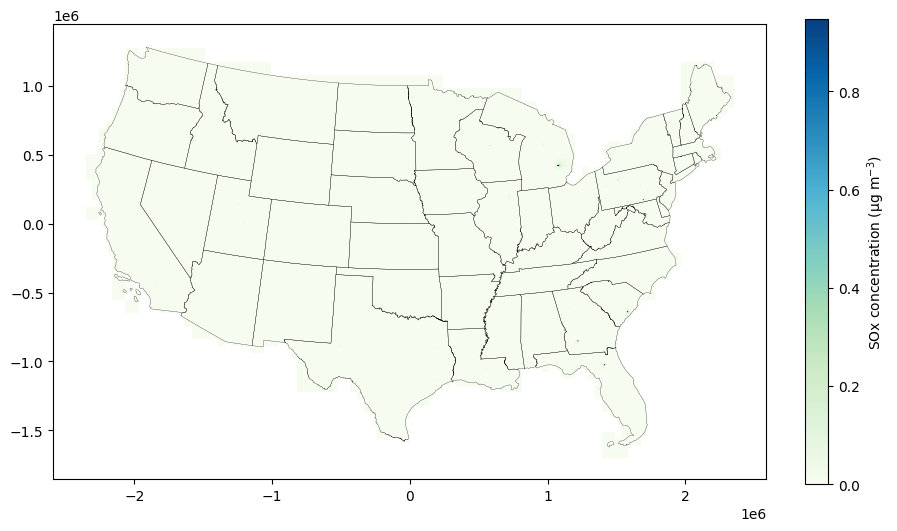

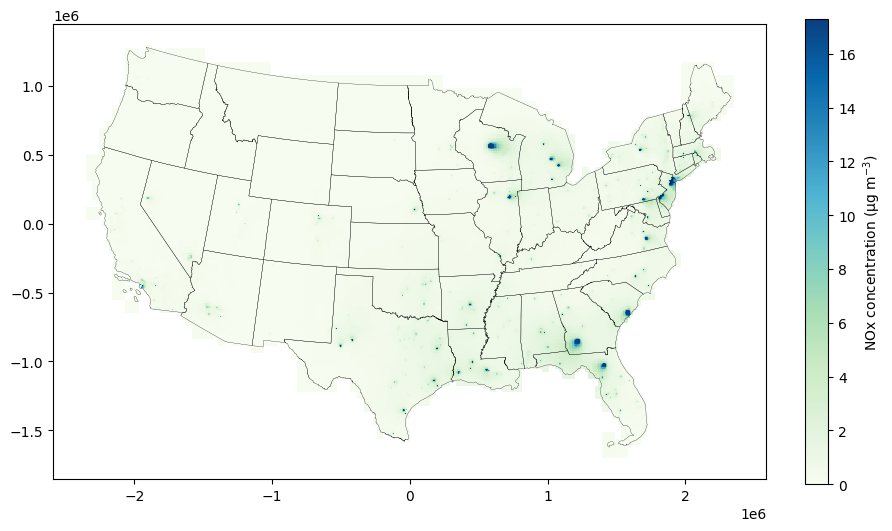

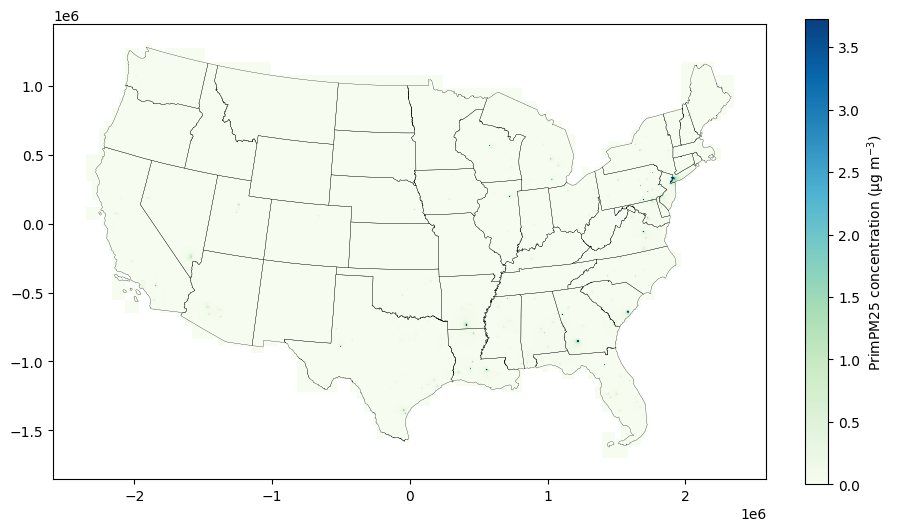

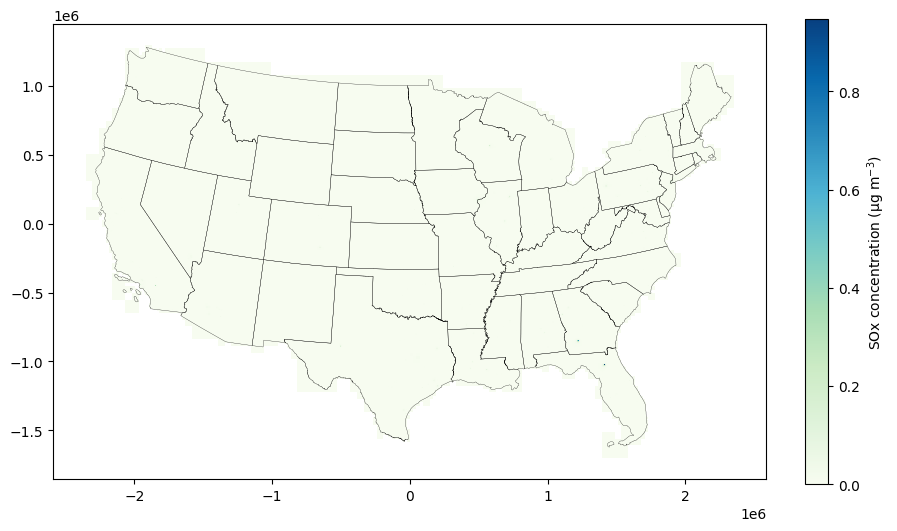

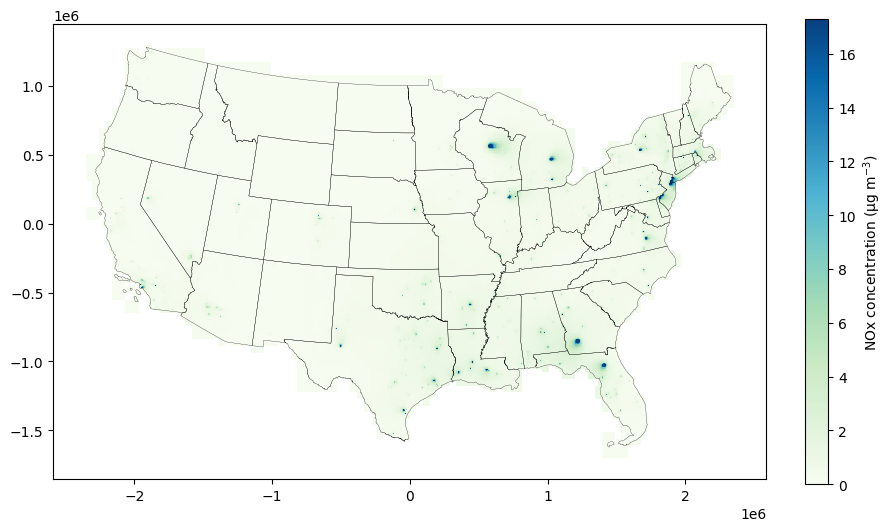

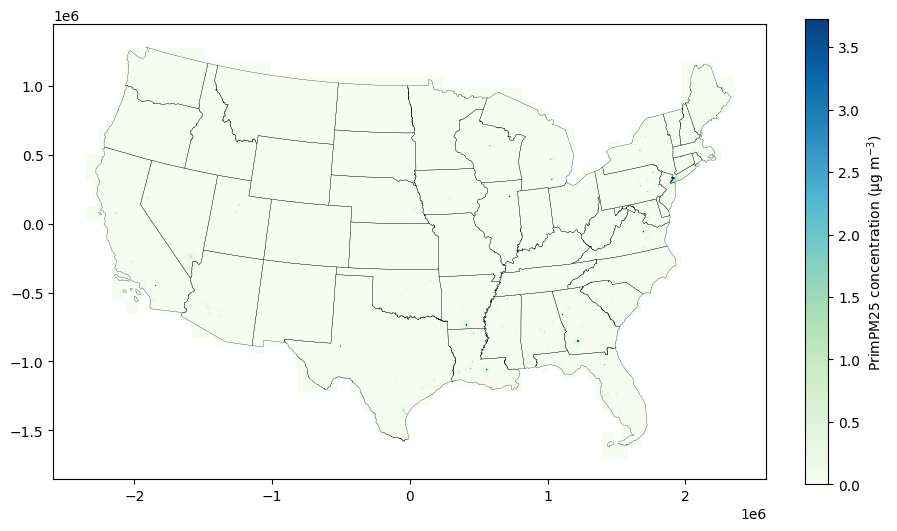

In [56]:
# Read the shapefiles
states = gpd.read_file('tl_2022_us_state/tl_2022_us_state.shp')
states = states[~states['STUSPS'].isin(['AS', 'AK', 'GU', 'MP', 'VI', 'HI', 'PR'])]


years = ['2030', '2040', '2050']
quant_dict={}
for year in years:
    emissions = gpd.read_file('InMap/MIP_InMap_Output/emissions'+year+'_out.shp')

    # Transform coordinates to match output
    #drop grid cells not in continental us
    states = states.to_crs(emissions.crs)
    intersects = emissions.geometry.intersects(states.unary_union)
    emissions['intersects'] = intersects
    emissions = emissions[emissions['intersects']==True]

    columns_to_plot = ['SOx', 'NOx', 'PrimPM25']
    for column in columns_to_plot:

        #want scales to be the same for each plot
        if year=='2030':
            q = 0.99  # Truncate results at the 99th percentile for better visualization
            cut = np.quantile(emissions[column], q)
            quant_dict[column]=cut

        fig, ax = plt.subplots(figsize=(10, 8))

        # Plot data with color scale truncated at the specified quantile
        emissions.plot(vmin=0, vmax=cut, cmap="GnBu", column=column, ax=ax)

        # Plot states boundaries
        states.boundary.plot(ax=ax, color='black', linewidth=0.2)

        # Add color bar
        sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=0, vmax=quant_dict[column]))
        sm._A = []  # Fake empty array for the colorbar
        cbar = fig.colorbar(sm, fraction=0.03)  
        cbar.set_label(column+' concentration (μg m$^{-3}$)')  # Set color bar label

        plt.savefig('MIP_AirPollution/Figures/Output/' + scenario + '/' + model + '/' +year+'_'+ column + '.jpg', format='jpg',
                    dpi=300, bbox_inches='tight')
